<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to the LSST data Butler</b> <br>
Last verified to run on <b>TBD</b> with LSST Science Pipelines release <b>TBD</b> <br>
Contact author: Alex Drlica-Wagner <br>
Credit: Originally developed by Alex Drlica-Wagner in the context of the LSST Stack Club <br>
Target audience: All DP0 delegates. <br>
Container Size: medium <br>
Questions welcome at <a href="https://community.lsst.org/c/support/dp0">community.lsst.org/c/support/dp0</a> <br>
Find DP0 documentation and resources at <a href="https://dp0-1.lsst.io">dp0-1.lsst.io</a> <br>

<br><br>
This notebook provides an introduction to the use of the data Butler. The Butler is the LSST Science Pipelines interface for managing, reading, and writing datasets. The Butler can be used to explore the contents of the DP0.1 data repository and access the DP0.1 data. The current version of the Butler (referred to as "Gen-3") is still under development, and this notebook may be modified in the future.

<br>
The goals of this notebook are to:<br>
1. create an instance of the Butler<br>
2. explore the DP0.1 data repository<br>
3. retrieve and display some image and catalog data<br>
4. create an image cutout at a user-specified coordinate<br>
5. retrieve and plot catalog data 



### Setup

In [5]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+8459b0669c 	w_2021_20 current setup


### 1. Create the Butler

In this section we are going to create an instance of the Butler. We start with some general python package imports.

In [6]:
# Generic imports
import os,glob
import pylab as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)

We import several packages from the LSST Science Pipelines. 
The first import gives us access to the Butler, while the second provides tools for displaying data.

More details and techniques regarding image display can be found in the `rubin-dp0` GitHub Organization's [tutorial-notebooks](https://github.com/rubin-dp0/tutorial-notebooks) repository.

In [7]:
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

To create the Butler, we need to provide it with a path to the data set, which is called a "data repository". Butler repositories can be remote (i.e., pointing to an S3 bucket) or local (i.e., pointing to a directory on the local file system). In this case, we point to an S3 bucket.

In [8]:
repo='s3://butler-us-central1-dp01'
butler = dafButler.Butler(repo)

### 2. Explore a data repository

Now that we've created an instance of the Butler, we can access the data `registry` (a database containing information about available data products). The registry will help us examine what collections of data products exist.

In [9]:
registry = butler.registry

# We can examine the registry with
#help(registry)

The `registry` is a good tool for investigating a repository (more on the registry schema can be found [here](https://dmtn-073.lsst.io/)). For example, we can get a list of all collections, with

In [10]:
for c in sorted(registry.queryCollections()):
    print(c)

2.2i/calib
2.2i/calib/PREOPS-301
2.2i/calib/PREOPS-301/unbounded
2.2i/calib/gen2
2.2i/calib/gen2/20220101T000000Z
2.2i/calib/gen2/20220806T000000Z
2.2i/defaults
2.2i/defaults/DP0
2.2i/defaults/test-med-1
2.2i/raw/DP0
2.2i/raw/all
2.2i/raw/test-med-1
2.2i/runs/DP0.1
2.2i/runs/DP0.1/calexp/v1
2.2i/runs/DP0.1/coadd/wfd/dr6/v1
2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy
2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u
refcats
refcats/PREOPS-301
skymaps


This is our first glimpse at the data contained in the repository, but it doesn't teach us *which* collection we are actually interested in. The names do give us some hints though...

* `2.2i` - refers to the processing run of the LSST DESC DC2 data (the `i` stands for `imSim`)
* `calib` - refers to calibration products that are used for instrument signature removal
* `runs` - refers to processed data products
* `refcats` - refers to the reference catalogs used for astrometric and photometric calibration
* `skymaps` - are the geometric representations of the sky coverage

Collections can be nested, so we can access everything for DC2 Run 2.2i (the primary DP0.1 data set) by selecting the collection `2.2i/runs/DP0.1`. This is a pointer to other collections that expand out recursively... More on collections can be found here: https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/organizing.html#collections

In [11]:
# If this collection is a pointer to other collections, expand those out recursively.
collection="2.2i/runs/DP0.1"
print(collection)
for c in sorted(registry.queryCollections(collection,flattenChains=True)):
    print(c, registry.getCollectionType(c))

2.2i/runs/DP0.1
2.2i/calib/PREOPS-301 CollectionType.CALIBRATION
2.2i/calib/PREOPS-301/unbounded CollectionType.RUN
2.2i/calib/gen2 CollectionType.CALIBRATION
2.2i/raw/DP0 CollectionType.TAGGED
2.2i/runs/DP0.1/calexp/v1 CollectionType.RUN
2.2i/runs/DP0.1/coadd/wfd/dr6/v1 CollectionType.RUN
2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy CollectionType.RUN
2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u CollectionType.RUN
refcats/PREOPS-301 CollectionType.RUN
skymaps CollectionType.RUN


We now create a new Butler instance specifying that we are specifically interested in the `2.2i/runs/DP0.1` data collection. For most uses, this will be the line you will use to create a Butler to work on DP0.1, since you now know that this collection exists.

In [12]:
# Create a new butler with the collection of interest
butler = dafButler.Butler(repo,collections=collection)
registry = butler.registry

You are probably interested in figuring out what kind of data is present in DP0.1. The LSST Science Pipelines classify different data products in terms of `DatasetTypes`. However, individual `DatasetTypes` are defined globally, and thus don't belong to a specific collection. Thus, a query of DatasetTypes will return all DatasetTypes belonging to the repository, and not all of them may belong to the collection of interest.

In [13]:
for x in sorted(registry.queryDatasetTypes()):
    print(x)

DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('cal_ref_cat_2_2', {htm7}, SimpleCatalog)
DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF)
DatasetType('calexpBackground', {band, instrument, detector, physical_filter, visit_system, visit}, Background)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('coaddDriver_config', {}, Config)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_calexp', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_calexp_background', {band, skymap, tract, patch}, Background)
DatasetType('deepCoadd_deblendedFlux', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedFlux_schema', {}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel_schema', {}, SourceCatalog)
DatasetType('deepCoadd_det', {band

Again, this list may seem a bit overwhelming, but we can extract some information from the names of the dataset types:

- `calexp` - refers to individual calibrated exposure
- `deepCoadd` - refers to products produced on the coadd images (both images and and source catalogs)
- `src` - refers to the catalog of sources
- `skyMap` - refers to geometric representations of the sky coverage

<b> Which data sets are most appropriate for DP0.1? </b><br>
Most DP0.1 delegates will only be interested in data sets with types `ExposureF` or `SourceCatalog`. 
For images, stick to the `calexp` (processed visit images, or PVIs) and `deepCoadd` (stacked PVIs).
For catalogs, the `src` should be used with the `calexp` images, and the `deepCoadd_forced_src` are the most appropriate to be used with the `coadds`.
More information can be found in the DP0.1 Data Products Definitions Document (DPDD) at [dp0-1.lsst.io](http://dp0-1.lsst.io).

<br>


We access specific data sets through a set of specifications known as a data identifier (`dataId`). Each `DatasetType` can be identified with a different set of properties, so it is important to be able to determine what properties need to be specified to access data of a specific type. It is possible to get all `DatasetRef` (which include the `dataId`) for a specific `datasetType` in a specific collection with a query like this. Note that this doesn't necessarily guarantee that the specific data set exists, so we include a check that the data set has a valid Uniform Resource Identifier (URI).

In [14]:
datasetRefs = registry.queryDatasets(datasetType='calexp',collections=collection)
for i,ref in enumerate(datasetRefs):
    print(ref.dataId.full)
    try: uri = butler.getURI(ref)
    except: print("File not found...")
    if i > 10: break

{band: 'r', instrument: 'LSSTCam-imSim', detector: 47, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 733724}
{band: 'r', instrument: 'LSSTCam-imSim', detector: 125, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 733724}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 1, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 956856}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 38, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 956856}
{band: 'i', instrument: 'LSSTCam-imSim', detector: 9, physical_filter: 'i_sim_1.4', visit_system: 1, visit: 976334}
{band: 'z', instrument: 'LSSTCam-imSim', detector: 46, physical_filter: 'z_sim_1.4', visit_system: 1, visit: 216823}
{band: 'z', instrument: 'LSSTCam-imSim', detector: 2, physical_filter: 'z_sim_1.4', visit_system: 1, visit: 748908}
{band: 'z', instrument: 'LSSTCam-imSim', detector: 39, physical_filter: 'z_sim_1.4', visit_system: 1, visit: 748908}
{band: 'z', instrument: 'LSSTCam-imSim', detector: 44, physical_fi

We can get the path from the URI that is returned by `butler.getURI`. Note that this URI does not refer to a local path on the filesystem. We do not need to know exactly where the data live in order to access it. That's the power of the Butler.

In [15]:
print("Repo path: ",repo)
uri = butler.getURI(ref)
print("File URI: ",uri)
!ls -lh {uri.ospath}

Repo path:  s3://butler-us-central1-dp01
File URI:  s3://butler-us-central1-dp01-desc-dr6/rerun/run2.2i-calexp-v1/calexp/00971990-z/R03/calexp_00971990-z-R03-S02-det020.fits
ls: cannot access {uri.ospath}: No such file or directory


Now say we want to restrict our selection to datasets associated with a specific filter. We can add that constraint to our query, but first we need to figure out what the filters are called... Looking at the dataId object, we see the attributes `physical_filter` and `band` look promising.

In [16]:
ref.dataId.full

{band: 'z', instrument: 'LSSTCam-imSim', detector: 20, physical_filter: 'z_sim_1.4', visit_system: 1, visit: 971990}

In [17]:
print(f"physical_filter = {ref.dataId['physical_filter']}")
print(f"band = {ref.dataId['band']}")

physical_filter = z_sim_1.4
band = z


It looks like `band` is what we want, so we include that in the `dataId` argument of `queryDatasets`. We can also select only visits with visit numbers larger than 700000 by adding a constraint in the `where` argument of `queryDatasets`. Let's try the $g$ band.

In [19]:
# You can also sub-select on specific properties of a data set
datasetRefs = registry.queryDatasets(datasetType='calexp',dataId={'band': 'g'}, where='visit > 700000', collections=collection)
for i,ref in enumerate(datasetRefs):
    print(ref.dataId.full)
    try: uri = butler.getURI(ref)
    except: print("File not found...")
    if i > 10: break

{band: 'g', instrument: 'LSSTCam-imSim', detector: 49, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 956856}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 108, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 960134}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 80, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 960134}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 66, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 960134}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 164, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 960134}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 90, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 960134}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 105, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 960134}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 181, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 990648}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 23, physi

### 3. Retrieve and plot a calexp with sources

Ok, now we have all the information we need to ask the Butler to get a specific data product. We have identified a collection (`2.2i/runs/DP0.1`), a `datasetType` (`calexp`), and the `dataId` (from the `datasetRef`) to uniquely specify an instance of this data set.

From the list above, let's choose one detector from one visit and ask the Butler to get a `calexp` for us.

In [20]:
# We could pass the datasetRef that we found above, but since the query may 
# return results in a different order we define the dataId explicitly for reproducibility. 
dataId = {'visit': '703697', 'detector': 80, 'band':'g'}
calexp = butler.get('calexp',dataId=dataId)

# This will print a warning related to the gen2 to gen3 Butler conversion that was performed on DP0.1

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/formatters/fitsExposure.py:533: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 80, visit: 703697} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


The `calexp` (also known as a "processed visit image," or PVI) is a calibrated CCD image from a single exposure. We'll use the afwDisplay interface to show the pixel values and mask plane (more on afwDisplay can be found in other notebooks).

<Figure size 576x576 with 0 Axes>

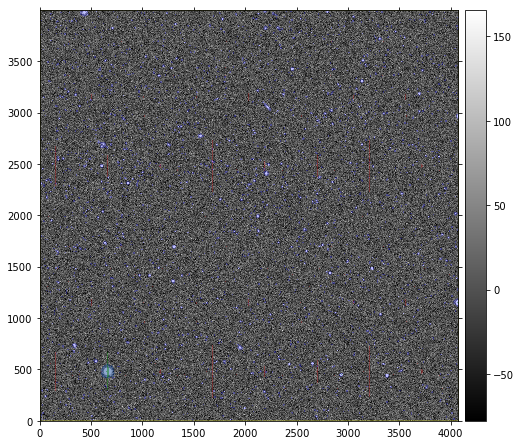

In [23]:
fig = plt.figure()
display = afwDisplay.Display()
display.scale('linear', 'zscale')
display.mtv(calexp)
plt.show()

Note the blue coloring of most sources in the above image (if you have sensitive eyes, you may also see some red streaks). The colors are set by the "mask" plane, which encodes things such as bad pixels, or ones that saturated (in this case, the blue pixels are those that are part of detected sources). See the Image Display and Manipulation tutorial for more about the mask plane. 

Now that we have a calibrated image, we may want to get the catalog of sources that were extracted from it. To get the `src` catalog associated with this `calexp` we pass the `dataId` to the butler with the `src` datasetType. Note that this performs another query to the registry database to find the `src` catalog that matches our dataId requirements.

In [24]:
# We could get the src table using the dataId as we did above for the calexp, 
# but this would require the butler to perform another query of the database. 
# Instead, we can just pass the ref itself directly to butler.get
src = butler.get('src',dataId)
src = src.copy(True)
src.asAstropy()

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_shapeHSM_Hs

We can now plot the `calexp` with the `src` catalog overlaid. We leave an investigation of this image as an exercise to the user :)

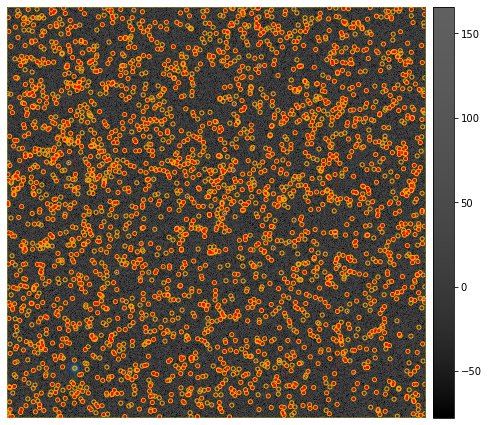

In [26]:
# And plot!
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    for s in src:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange') 

### 4. How to query for multiple data sets

In the case above, both the `calexp` and `src` can be found by the registry, but this will not always necessarily be the case. The `queryDataIds` method provides a more flexible way to query for multiple datasets (requiring an instance of all datasets to be available for that dataId) or ask for different dataId keys than what is used to identify the dataset (which invokes various built-in relationships). An example of this is provided below:

In [31]:
# Use queryDataIds to grab the dataIds for a subset taken from a single visit
dataIds = registry.queryDataIds(["visit", "detector", "band"], datasets=["calexp","src"], where='visit = 703697',
                                collections=collection)
for i,dataId in enumerate(dataIds):
    print(dataId.full)
    if i > 10: break

{band: 'g', instrument: 'LSSTCam-imSim', detector: 111, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 116, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 113, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 115, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 109, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 110, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 112, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 114, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 108, 

In [32]:
# Use queryDataIds to grab the dataIds for a subset using the "where" functionality
dataIds = registry.queryDataIds(["visit", "detector"], datasets=["calexp","src"], 
                                where="band='g' and detector=0 and visit > 700000",
                                collections=collection)
for i,dataId in enumerate(dataIds):
    print(dataId.full)
    if i > 10: break

{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703697}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703698}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703699}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703700}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703723}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703742}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703743}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: 'g_sim_1.4', visit_system: 1, visit: 703744}
{band: 'g', instrument: 'LSSTCam-imSim', detector: 0, physical_filter: '

You can also get more metadata about a data product dimension. (Note that the record for an exposure and a visit are different.)

In [33]:
# Use queryDimensions to provide more flexible access
for dim in ['exposure','visit','detector']:
    print(list(registry.queryDimensionRecords(dim, where='visit = 971990 and detector=0'))[0])
    print()

exposure:
  instrument: 'LSSTCam-imSim'
  id: 971990
  physical_filter: 'z_sim_1.4'
  obs_id: '971990'
  exposure_time: 30.0
  dark_time: 30.0
  observation_type: 'science'
  observation_reason: 'imsim'
  day_obs: 20251201
  seq_num: 0
  group_name: '971990'
  group_id: 971990
  target_name: 'UNKNOWN'
  science_program: '971990'
  tracking_ra: 70.37699524983329
  tracking_dec: -37.17573628348882
  sky_angle: 292.6518874660149
  zenith_angle: 19.469782456426444
  timespan: Timespan(begin=astropy.time.Time('2025-12-02 03:11:50.174400', scale='tai', format='iso'), end=astropy.time.Time('2025-12-02 03:12:20.174000', scale='tai', format='iso'))

visit:
  instrument: 'LSSTCam-imSim'
  id: 971990
  physical_filter: 'z_sim_1.4'
  visit_system: 1
  name: '971990'
  day_obs: 20251201
  exposure_time: 30.0
  target_name: 'UNKNOWN'
  observation_reason: 'imsim'
  science_program: '971990'
  zenith_angle: 19.469782456426444
  region: ConvexPolygon([UnitVector3d(0.2358889117749739, 0.762252663301114

### 5. Generate an Image Cutout

Say we want to grab a cutout of the DP0.1 coadded images at a specific location. In order to do this, we need a few other packages from the LSST Science Pipelines. In particular, access to the geometry and coordinate packages.

In [34]:
import lsst.geom as geom
import lsst.afw.coord as afwCoord

In [35]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given afw SpherePoint radec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string 
        Filter of the image to load
    datasetType: string ['deepCoadd']  
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional] 
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional] 
        Side of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")
    
    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox':bbox}
    
    cutout_image = butler.get(datasetType, parameters=parameters, immediate=True, dataId=coaddId)
    
    return cutout_image

In [36]:
ra,dec = 55.064, -29.783 # center of the DC2 region
cutout_image = cutout_coadd(butler,ra,dec,datasetType='deepCoadd', cutoutSideLength=201)
print("The size of the cutout is: ",cutout_image.image.array.shape)

The size of the cutout is:  (201, 201)


(6604.5, 6805.5, 26716.5, 26917.5)

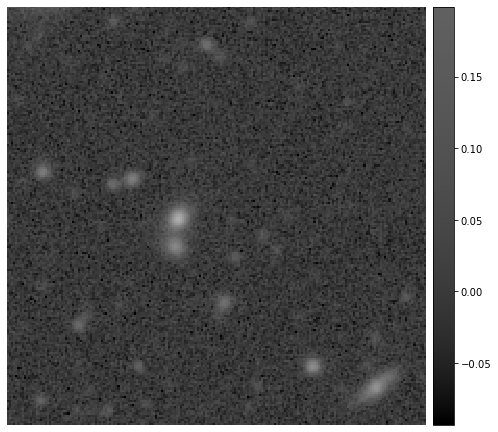

In [37]:
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout_image.image)
plt.gca().axis('off')

### 6. Retrieve and plot catalog data from the Butler

The TAP service is the recommended way to retrieve DP0.1 catalog data for a notebook, and there are several other tutuorials that demonstrate how to use the TAP service.

But if Butler access to catalog data is needed, an easy way to start is by retrieving only the schema data set for a Butler catalog, which can be done without specifying the ``dataId``. 

In [38]:
schema_coadd_src = butler.get('deepCoadd_forced_src_schema')
schema_coadd_src.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssCentroid_flag_badInitialCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,undeblended_base_CircularApertureFlux_flag_badCentroid,undeblended_base_PsfFlux_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_0_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_1_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_2_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_3_flag_badCentroid,undeblended_ext_convolved_ConvolvedFlux_flag_badCentroid,undeblended_ext_photometryKron_KronFlux_flag_badInitialCentroid,base_InputCount_flag,base_InputCount_value,base_InputCount_flag_noInputs,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_TransformedShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,modelfit_DoubleShapeletPsfApprox_0_xx,modelfit_DoubleShapeletPsfApprox_0_yy,modelfit_DoubleShapeletPsfApprox_0_xy,modelfit_DoubleShapeletPsfApprox_0_x,modelfit_DoubleShapeletPsfApprox_0_y,modelfit_DoubleShapeletPsfApprox_0_0,modelfit_DoubleShapeletPsfApprox_0_1,modelfit_DoubleShapeletPsfApprox_0_2,modelfit_DoubleShapeletPsfApprox_0_3,modelfit_DoubleShapeletPsfApprox_0_4,modelfit_DoubleShapeletPsfApprox_0_5,modelfit_DoubleShapeletPsfApprox_1_xx,modelfit_DoubleShapeletPsfApprox_1_yy,modelfit_DoubleShapeletPsfApprox_1_xy,modelfit_DoubleShapeletPsfApprox_1_x,modelfit_DoubleShapeletPsfApprox_1_y,modelfit_DoubleShapeletPsfApprox_1_0,modelfit_DoubleShapeletPsfApprox_1_1,modelfit_DoubleShapeletPsfApprox_1_2,modelfit_DoubleShapeletPsfApprox_flag,modelfit_DoubleShapeletPsfApprox_flag_invalidPointForPsf,modelfit_DoubleShapeletPsfApprox_flag_invalidMoments,modelfit_DoubleShapeletPsfApprox_flag_maxIterations,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncat

Each of the following lines will print the schema to the screen in different ways.

In [39]:
# schema_coadd_src.schema
# schema_coadd_src.schema.getNames()
# schema_coadd_src.schema.getOrderedNames()
print('Number of columns in this table = ', len(schema_coadd_src.schema.getNames()) )

Number of columns in this table =  508


Perhaps you want to search for all schema elements that contain the term 'psf'.

In [40]:
# Define an array that is all of the column names
all_names = schema_coadd_src.schema.getOrderedNames()

# Loop over the names and look for the term 'psf'
for i,name in enumerate(all_names):
    if name.find('psf') >= 0:
        print( i, name )
del all_names

32 base_SdssShape_psf_xx
33 base_SdssShape_psf_yy
34 base_SdssShape_psf_xy
43 base_SdssShape_flag_psf
139 base_PixelFlags_flag_inexact_psfCenter
144 base_PixelFlags_flag_inexact_psf
159 ext_photometryKron_KronFlux_psf_radius
162 ext_photometryKron_KronFlux_flag_bad_shape_no_psf
167 ext_photometryKron_KronFlux_flag_used_psf_radius
332 undeblended_ext_photometryKron_KronFlux_psf_radius
335 undeblended_ext_photometryKron_KronFlux_flag_bad_shape_no_psf
340 undeblended_ext_photometryKron_KronFlux_flag_used_psf_radius


Probably you will want to know more about the values in these columns. You can do that by printing the documentation string in the schema.

In [41]:
# Turn the schema into a python dictionary, to be able to call a column by name
schema_dict = schema_coadd_src.schema.extract('*')

# Print the associated docstring for each of the named columns of interest
for name in ['base_SdssShape_psf_xx','base_SdssShape_psf_yy','base_SdssShape_psf_xy']:
    doc = schema_dict[name].getField().getDoc()
    print(name, ' = ', doc)

base_SdssShape_psf_xx  =  adaptive moments of the PSF model at the object position
base_SdssShape_psf_yy  =  adaptive moments of the PSF model at the object position
base_SdssShape_psf_xy  =  adaptive moments of the PSF model at the object position


Refer to the DP0.1 Data Products Definitions Document (DPDD) at [dp0-1.lsst.io](http://dp0-1.lsst.io) to find out more about the columns.

<br>
The catalogs are very large and it is not feasible to try and retrieve them in their entirety.
Instead, in this example we identify the tract and patch of interest and retrieve only catalog data for a small region of sky.
We use the same ra and dec coordinates as above to find the patch and tract.

In [42]:
radec = geom.SpherePoint(ra, dec, geom.degrees)

skymap = butler.get("skyMap")

tractInfo = skymap.findTract(radec)
tract = tractInfo.getId()

patchInfo = tractInfo.findPatch(radec)
patch = tractInfo.getSequentialPatchIndex(patchInfo)

print(tract, patch)

coaddId = {'tract': tract, 'patch': patch, 'band':'i'}

coadd_src = butler.get('deepCoadd_forced_src',coaddId)
coadd_src = src.copy(True)

4638 43


In [43]:
# Show the table contents if desired
# coadd_src.asAstropy()

<br>

Convert to a Pandas dataframe (see the first tutorial) for easy interaction.
The following cells offer options for printing the column names or the data values.

In [44]:
data = coadd_src.asAstropy().to_pandas()

In [45]:
# print(data.columns)

In [46]:
# for col in data.columns:
#     print(col)

In [47]:
# data['coord_ra'].values

Plot the locations of sources in the patch.

Text(0.5, 1.0, 'Butler coadd_forced_src objects in tract 4638 patch 43')

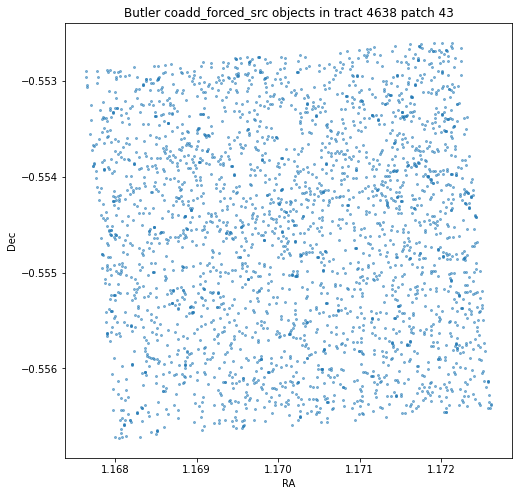

In [48]:
fig = plt.figure()
plt.plot( data['coord_ra'].values, data['coord_dec'].values, 'o', ms=2, alpha=0.5 )
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Butler coadd_forced_src objects in tract 4638 patch 43')

As a final note -- did you notice that the RA and Dec columns (`coord_ra` and `coord_dec`, specifically) have units of _radians_? As an exercise, you could use what you've learned from above to confirm this by accessing the table schema. (Also note that you can scroll up and find the answer in the outputs from a cell you already executed.) 